In [38]:
import pretty_midi
import glob
import numpy as np
import gensim
import music21
import sklearn
import random
import json

from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import output_file, output_notebook, ColumnDataSource, figure, show
from bokeh.models import HoverTool

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [39]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

def transpose_to_all(c):
    out = []
    old = c
    for i in range(12):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out
        
def c_to_strep(c):
    rep = ""
    for i in range(12):
        if i in c.pitchClasses:
            rep += "1"
        else:
            rep += "0"
    return rep

def strep_to_c(strep):
    pcs = []
    for i, v in enumerate(strep):
        if v == '1':
            pcs.append(i)
    return music21.chord.Chord(pcs)

In [72]:
composers =['Mozart',
 'Beethoven',
 'Haydn',
 'Scarlatti',
 'Bach',
 'Schubert',
 'Liszt',
 'Chopin',
 'Brahms',
 'Saint-Saens',
 'Mendelssohn',
 'Dvorak',
 'Telemann',
 'Tchaikovsky',
 'Schumann',
 'Handel',
 'Wagner',
 'Vivaldi',
 'Hummel',
 'Verdi']

In [78]:
ns = {}

for composer in composers:
    ns[composer] = len(json.load(open('{}.json'.format(composer))))

In [92]:
ns['ycac'] = len(json.load(open('{}.json'.format('ycac'))))

In [93]:
ns

{'Bach': 652,
 'Beethoven': 366,
 'Brahms': 166,
 'Chopin': 204,
 'Dvorak': 117,
 'Handel': 191,
 'Haydn': 363,
 'Hummel': 101,
 'Liszt': 125,
 'Mendelssohn': 137,
 'Mozart': 882,
 'Saint-Saens': 137,
 'Scarlatti': 617,
 'Schubert': 223,
 'Schumann': 167,
 'Tchaikovsky': 94,
 'Telemann': 224,
 'Verdi': 91,
 'Vivaldi': 167,
 'Wagner': 58,
 'ycac': 4618}

In [94]:
def generate_embeddings(composer):
    docs = json.load(open('{}.json'.format(composer)))
    
    chunked_docs = []

    for doc in docs:
        chunked_docs.extend([x for x in chunks(doc, 32)])
        
    sentences = chunked_docs

    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    
    return model

In [95]:
def plot_relations(a, b, composer):
    
    model = generate_embeddings(composer)
    
    n = ns[composer]
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    # tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)

    all_a = [c_to_strep(x) for x in transpose_to_all(a)]
    all_b = [c_to_strep(x) for x in transpose_to_all(b)]

    pairs = zip(all_a, all_b)
    focus = all_a + all_b
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [words.index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]

    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]))
        
    def lookup_strep(strep):
        i = words.index(strep)
        return (proj[i, 0], proj[i, 1])
        
    arrows = [map(lookup_strep, pair) for pair in pairs]

    arrow_params = {'length_includes_head': True,
                    'head_starts_at_zero': True}
    
    for arrow in arrows:
        ax.arrow(arrow[0][0], arrow[0][1], arrow[1][0] - arrow[0][0], arrow[1][1] - arrow[0][1], alpha=0.3, 
             linewidth=1, head_width=.05, head_length=.05, **arrow_params)
    
    ax.scatter(x, y, c='black')
    
    ax.set_title('{composer} (no. of docs = {n}) PCA'.format(composer=composer, n=n))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    f.show()

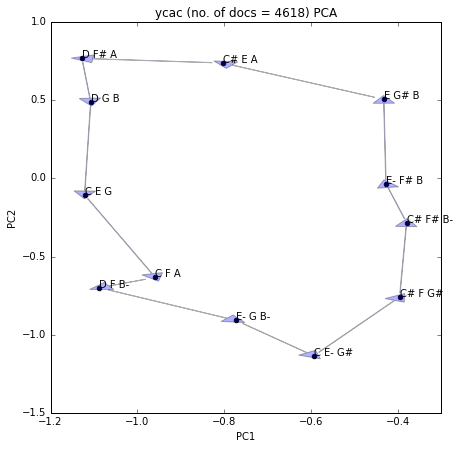

In [96]:
a = music21.chord.Chord(['A', 'C#', 'E'])
b = music21.chord.Chord(['D', 'F#', 'A'])

plot_relations(a, b, 'ycac')